# Code Test
(test generated data extracted from the video)

Landmark Tensor Shape: (37015, 68, 2)
Frame Distance From Ref Array Length: (37015,)


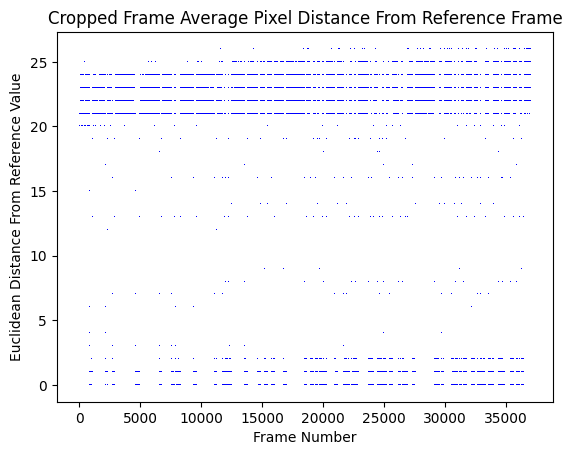

In [4]:
import numpy as np
import matplotlib.pyplot as plt

landmark_tensor = np.load("data/AmitS_landmark.npy")
print(f"Landmark Tensor Shape: {landmark_tensor.shape}")

distances = np.load("data/AmitS_distance.npy")
print(f"Frame Distance From Ref Array Length: {distances.shape}")

x = range(distances.shape[0])
plt.plot(x, distances, ',b')
plt.title("Cropped Frame Average Pixel Distance From Reference Frame")
plt.xlabel("Frame Number")
plt.ylabel("Euclidean Distance From Reference Value")
plt.show()


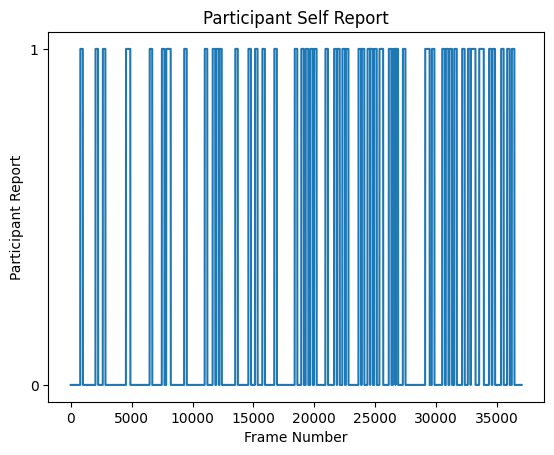

In [5]:
middle_distance = np.max(distances) // 2
roundBinary = np.vectorize(lambda t: 1 if (t < middle_distance) else 0)
binary_report = roundBinary(distances)
binary_report = np.concatenate((np.split(binary_report, [30])[1], np.zeros(30)))

plt.plot(x, binary_report)
plt.title("Participant Self Report")
plt.xlabel("Frame Number")
plt.ylabel("Participant Report")

plt.yticks([0, 1])

plt.show()